# INTRODUCTION

This Python project analyzes the relationship between socio-economic factors and opioid overdose deaths across counties in New York State. The analysis explores variables such as poverty rates, high school dropout rates, mental health, and healthcare access to determine their predictive power regarding opioid-related fatalities, with the aim of uncovering insights that can inform public health strategies and interventions.

*Next steps: A split rural-urban analysis seems best, as these areas appear to behave differently than one another regarding opioid death trends. However, we don't have enough data from which to draw conclusive results in this way. So, we'll repeat this analysis for counties across the nation and see if clearer trends emerge. For this national analysis, we'll proceed in a new notebook.*

# IMPORTS

In [3]:
import pandas as pd
import numpy as np
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# LOAD DATA

In [5]:
path = './data/'

opioids = pd.read_csv(path + 'OP-CountyData.xlsx - Opioid dashboard - Mortality.csv') # from https://apps.health.ny.gov/public/tabvis/PHIG_Public/opioid/#dataexport
dropouts = pd.read_csv(path + 'Community_Health__Percentage_of_High_School_Drop_Outs_by_County_Map__Latest_Data.csv') # from https://www.data.ny.gov/ru/browse?q=dropout&sortBy=relevance
poverty = pd.read_csv(path + '2019_nys_poverty_rates.csv') # from https://www.census.gov/data/datasets/2019/demo/saipe/2019-state-and-county.html
mental_health_healthcare = pd.read_csv(path + 'Behavioral_Risk_Factor_Surveillance_System__BRFSS__Health_Indicators_by_County_and_Region_20240806.csv') # from https://www.health.ny.gov/statistics/brfss/ Data available from 2018, 2021. Using 2018 since 2021 may be swayed by covid
unemployment = pd.read_csv(path + 'nys-dol-2019-unemployment.csv')
urban_rural = pd.read_csv(path + '2020_UA_COUNTY-Table 1.csv')

# CLEANING DATA

## CLEANING OPIOID DATASET

In [8]:
opioids = opioids[opioids['Data Years'] == 2019]
opioids = opioids[opioids['Indicator Number'] == 'opd3']
opioids = opioids[~opioids['County Name'].isin([
    'New York State',
    'New York State (excluding NYC)',
    'New York City',
    'Long Island',
    'Mid-Hudson',
    'Western NY',
    'Mohawk Valley',
    'Finger Lakes',
    'Central Region',
    'Capital Region',
    'Central NY',
    'North Country',
    'Southern Tier',
    'Tug Hill Seaway'
])] # remove already-aggregated rows

opioids.loc[opioids['Event Count/Rate'] == 's', ['Event Count/Rate', 'Percentage/Rate']] = '0'

# Event Count/Rate of 's' indicates that the numbers are not high enough to count
# Same for Percentage/Rate
# (source: https://oasas.ny.gov/system/files/documents/2022/09/hamilton_county_key_sud_indicators_06152022.pdf)
# I can safely replace them with 0's

opioids.loc[:,'Percentage/Rate'] = opioids['Percentage/Rate'].str.replace('*', '')

opioids[['Percentage/Rate']] = opioids[['Percentage/Rate']].apply(pd.to_numeric)
opioids = opioids.loc[:,['Region','County Name','Percentage/Rate']]
opioids = opioids.rename(columns={'Percentage/Rate':'Opioid Deaths per 100000'})
# opioids now stands for: opioid overdose deaths per 100000 people in 2019, by county

## CLEANING DROPOUTS DATA

In [10]:
# dropouts: 2015-2017 dropout rates by county
dropouts = dropouts[['County Name', 'Event Count', 'Percent/Rate']]
dropouts = dropouts.rename(columns={'Event Count':'Dropouts', 'Percent/Rate':'Dropout Percentage'})
dropouts[['Dropouts','Dropout Percentage']] = dropouts[['Dropouts','Dropout Percentage']].fillna(0)
# NAs here indicate there isn't enough data. Just for Hamilton county, it seems, same as for opioids.
# Fill with 0's for now, but keep in mind that Hamilton county (the lowest populated county in NYS) is a potential outlier
# Maybe just remove it later.

## CLEANING POVERTY DATA

In [12]:
poverty = poverty.loc[:,['County Name', 'Poverty Count', 'Poverty Percentage']]
poverty.loc[:,'County Name'] = poverty['County Name'].str.strip()
poverty = poverty[poverty['County Name'] != 'New York'] # Filter out aggregate data for state. Leaves in New York County.
poverty.loc[:,'County Name'] = poverty['County Name'].str.replace(' County', '')

## CLEANING MENTAL HEALTH

In [14]:
poor_mental_health = mental_health_healthcare[mental_health_healthcare['Health Indicator Short Name'] == 'Poor Mental Health']
poor_mental_health = poor_mental_health[poor_mental_health['Year'] == '2018']
poor_mental_health = poor_mental_health[poor_mental_health['Geography'] == 'County']
poor_mental_health = poor_mental_health[['Region/County', 'Crude Rate']]
poor_mental_health = poor_mental_health.rename(columns={'Region/County':'County Name','Crude Rate':'Poor Mental Health Percentage'})

# Poor Mental Health Percentage is percentage of adults in 2018 who reported 14 or more
# bad mental health days per month, according to the BRFSS codebook here:
# https://www.cdc.gov/brfss/annual_data/2021/pdf/2021-calculated-variables-version4-508.pdf

## CLEANING HEALTHCARE DATA

In [16]:
healthcare = mental_health_healthcare[mental_health_healthcare['Health Indicator Short Name'].isin(['No Medical Care Due to Cost','Recent Checkup'])]
healthcare = healthcare[healthcare['Year'] == '2018']
healthcare = healthcare[healthcare['Geography'] == 'County']
healthcare = healthcare[['Region/County', 'Health Indicator Short Name', 'Crude Rate']]

no_med_care = healthcare[healthcare['Health Indicator Short Name'] == 'No Medical Care Due to Cost']
no_med_care = no_med_care.rename(columns={'Crude Rate':'No Medical Care Due to Cost Percentage'})

checkup = healthcare[healthcare['Health Indicator Short Name'] == 'Recent Checkup']
checkup = checkup.rename(columns={'Crude Rate':'Recent Checkup Percentage'})

# Keep the two indicators in one table to work with more efficiency

healthcare = pd.merge(checkup[['Region/County','Recent Checkup Percentage']],
                     no_med_care[['Region/County','No Medical Care Due to Cost Percentage']],
                     on='Region/County')
healthcare = healthcare.rename(columns={'Region/County':'County Name'})


# No Medical Care Due to Cost is the percentage of people in 2018 who, in the previous year, needed
# to see a doctor but couldn't due to cost, according to the BRFSS codebook here:
# https://www.cdc.gov/brfss/annual_data/2021/pdf/codebook21_llcp-v2-508.pdf

# Checkup Within Past Year is the percentage of adults aged 18-64 in 2018 who saw a doctor for
# a routine checkup within the last year

## CLEANING UNEMPLOYMENT DATA

In [18]:
unemployment['RATE'] = unemployment['RATE'].str.replace('%', '')
unemployment['RATE'] = unemployment['RATE'].astype(float)
unemployment = unemployment.rename(columns={'COUNTY':'County Name', 'RATE': 'Unemployment Percentage'})

## CLEANING URBAN/RURAL DATA

In [20]:
urban_rural = urban_rural.loc[urban_rural['STATE_NAME'] == 'New York']
urban_rural = urban_rural.loc[:,['COUNTY_NAME','URBANBLOCKS','RURALBLOCKS']]
urban_rural['COUNTY_NAME'] = urban_rural['COUNTY_NAME'].str.replace(' *','')
urban_rural['URBANBLOCKS'] = urban_rural['URBANBLOCKS'].str.replace(',','').astype(float)
urban_rural['RURALBLOCKS'] = urban_rural['RURALBLOCKS'].str.replace(',','').astype(float)
urban_rural.loc[urban_rural['COUNTY_NAME'] == 'New York','RURALBLOCKS'] = 1 # to avoid dividing by 0
urban_rural.loc[:,'Urban Score'] = urban_rural['URBANBLOCKS'] / urban_rural['RURALBLOCKS']
# urban score = number of urban blocks / number of rural blocks
# urban score less than 1 indicates a more rural area, greater than 1 indicates a more urban area
# higher urban score = more urban, lower indicates more rural
urban_rural.loc[:,'IsUrban'] = np.where(urban_rural['Urban Score'] < 1, 0, 1)

urban_rural = urban_rural.loc[:,['COUNTY_NAME','Urban Score','IsUrban']]
urban_rural = urban_rural.rename(columns={'COUNTY_NAME':'County Name'})

# MERGING DATA

In [22]:
opioids_factors = opioids.merge(dropouts, on='County Name')
opioids_factors = opioids_factors.merge(poverty, on='County Name')
opioids_factors = opioids_factors.merge(poor_mental_health, on='County Name')
opioids_factors = opioids_factors.merge(healthcare, on='County Name')
opioids_factors = opioids_factors.merge(unemployment, on='County Name')
opioids_factors = opioids_factors.merge(urban_rural, on='County Name')

# UNIVARIATE ANALYSIS

Our datasets are all roughly normal and symmetric. Each have one or two minor outliers, which do not significantly skew the dataset one way or the other.

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


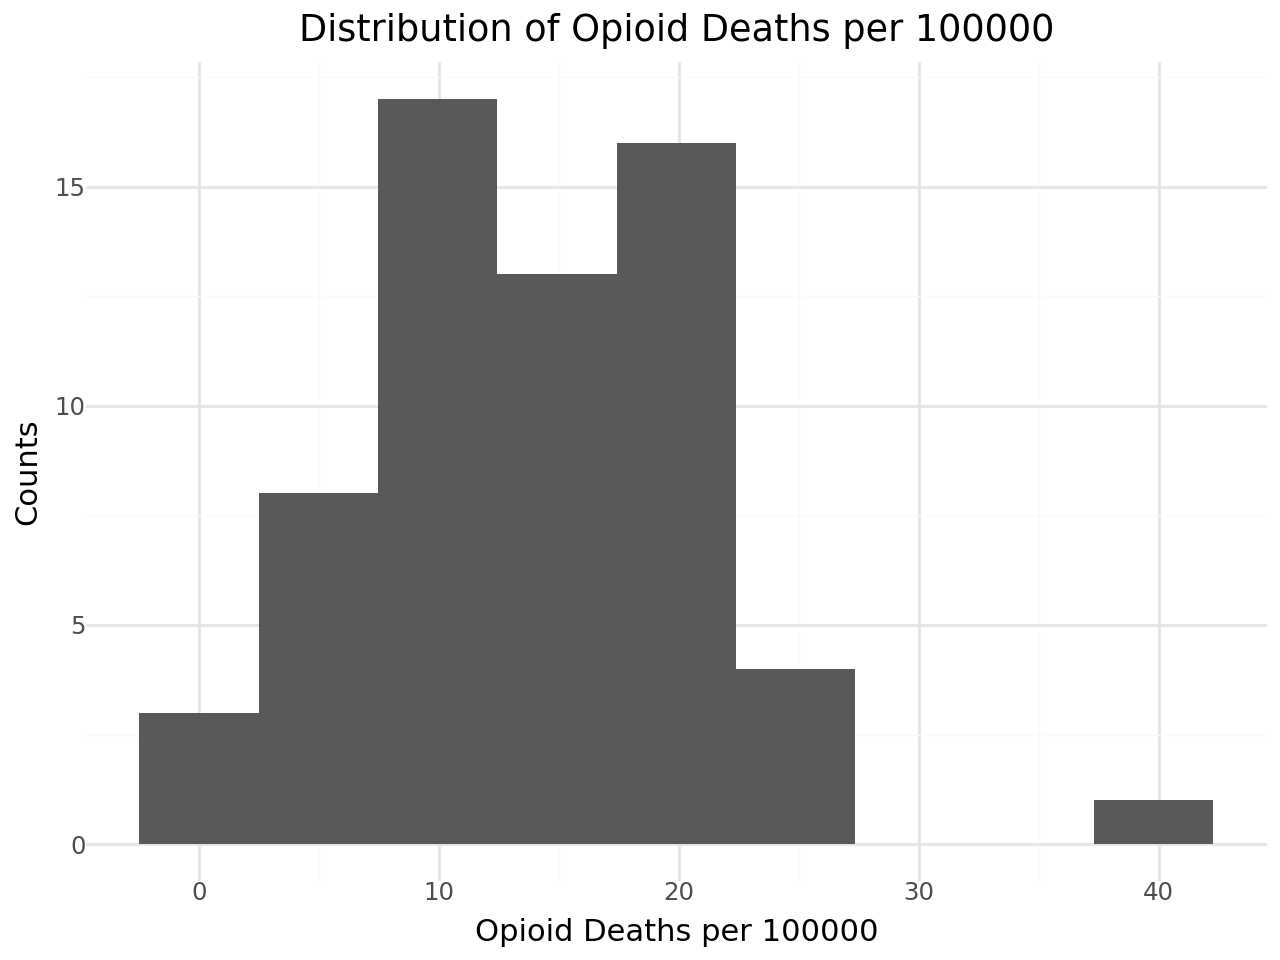

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


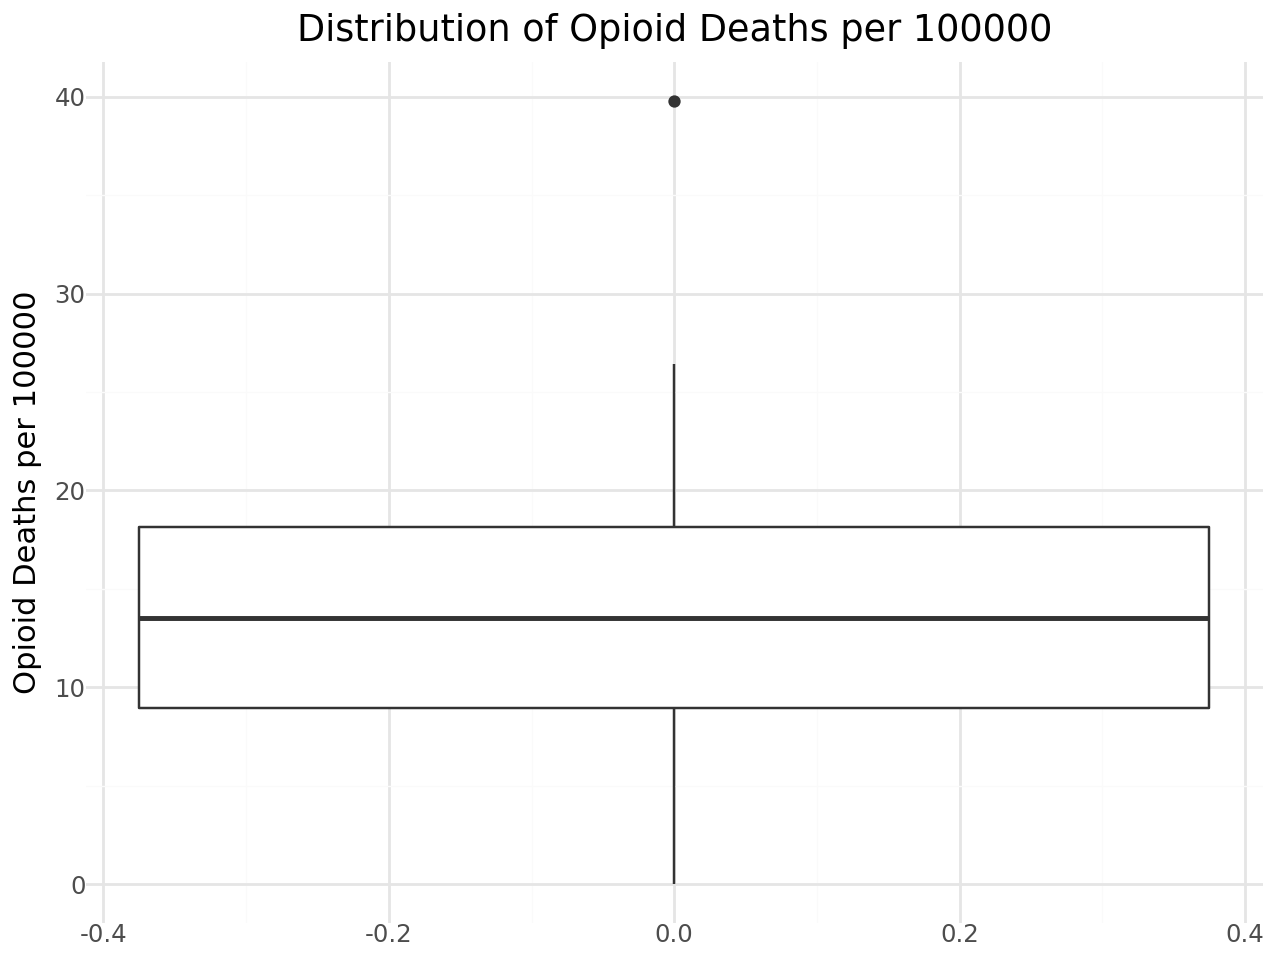


count    62.00
mean     13.74
std       7.30
min       0.00
25%       8.95
50%      13.50
75%      18.15
max      39.80
Name: Opioid Deaths per 100000, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 11'. Pick better value with 'binwidth'.


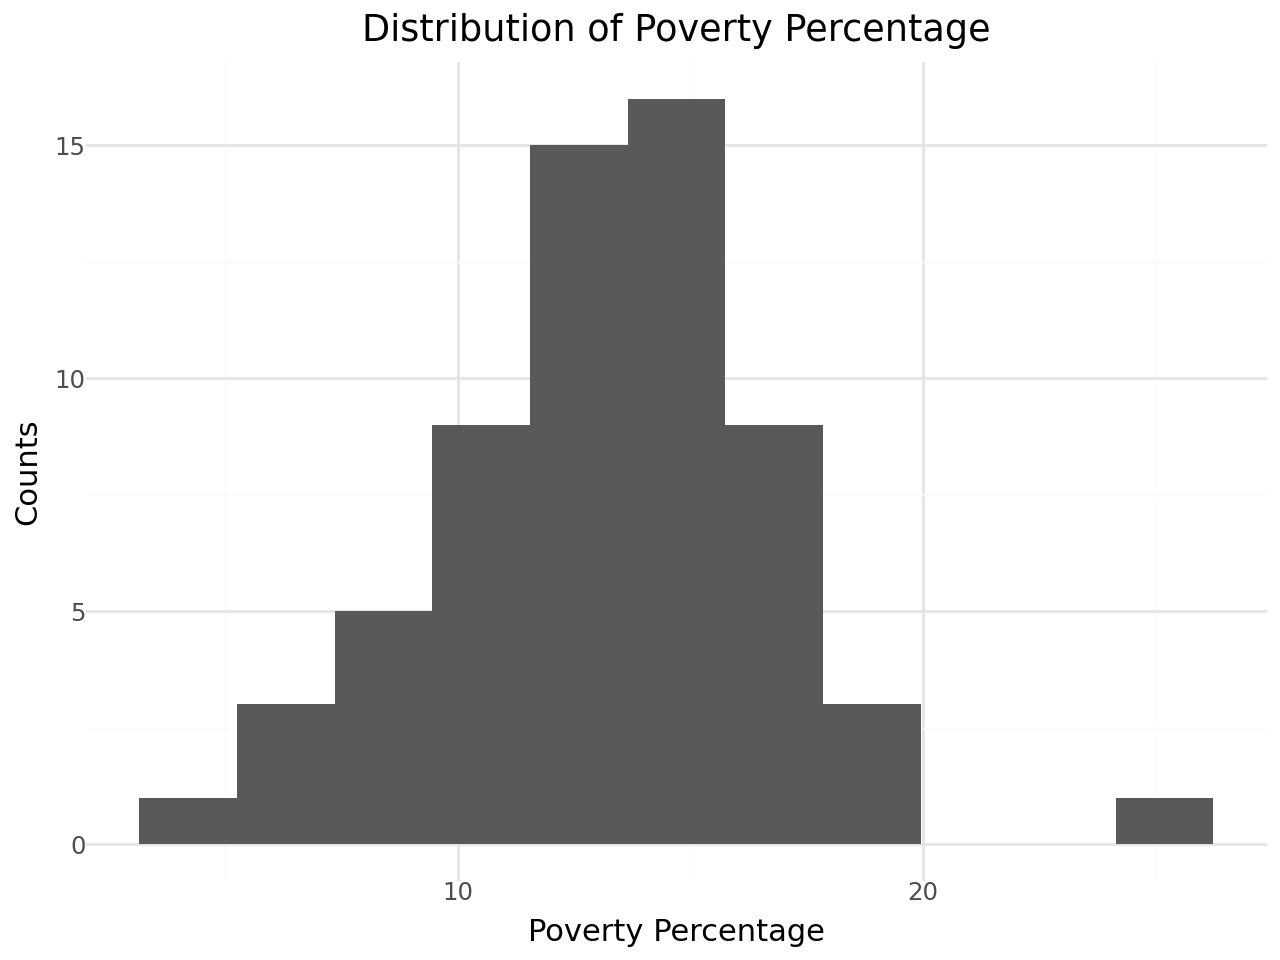

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


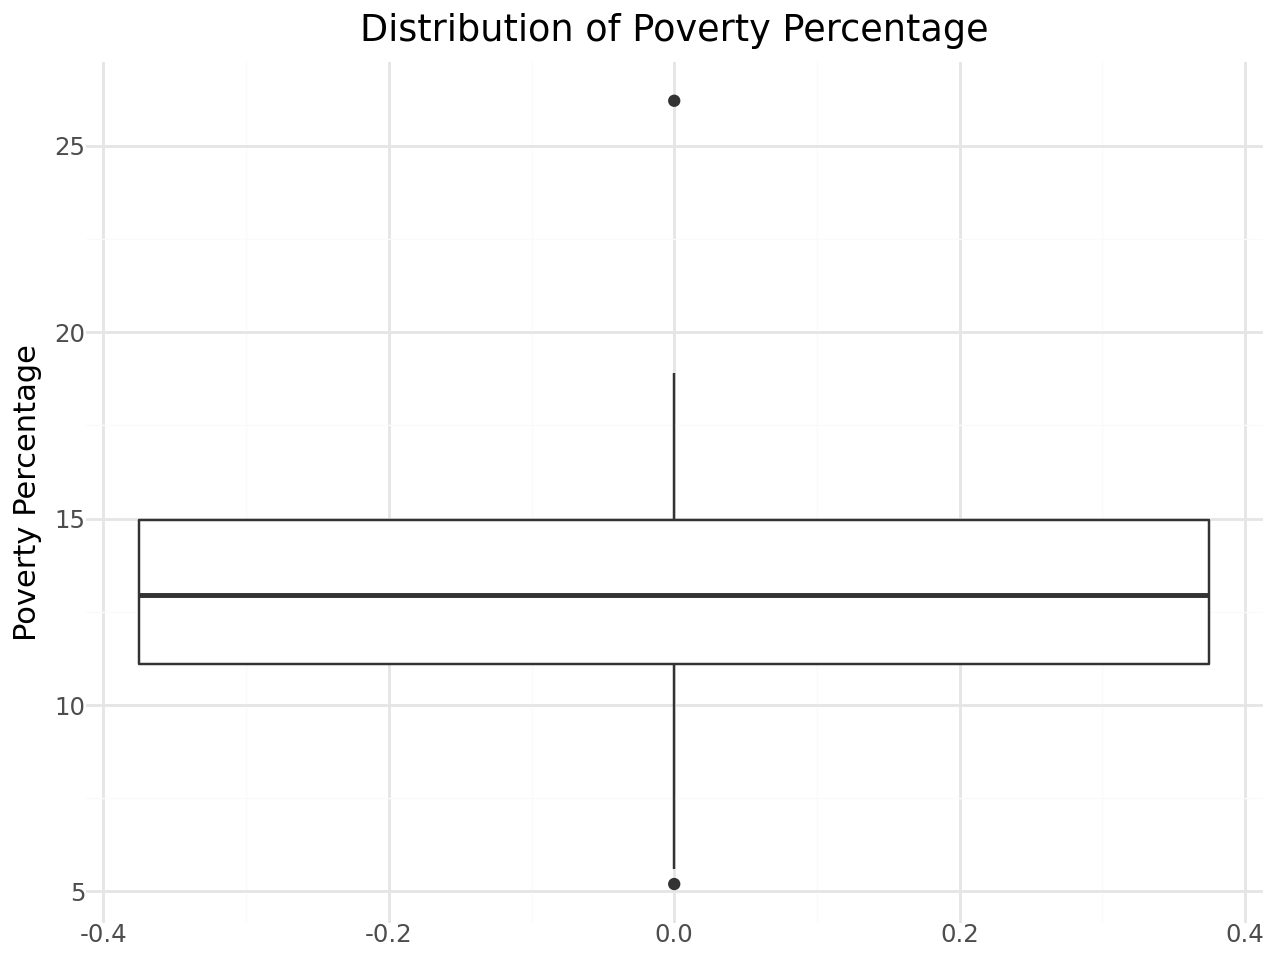


count    62.00
mean     13.05
std       3.60
min       5.20
25%      11.10
50%      12.95
75%      14.95
max      26.20
Name: Poverty Percentage, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


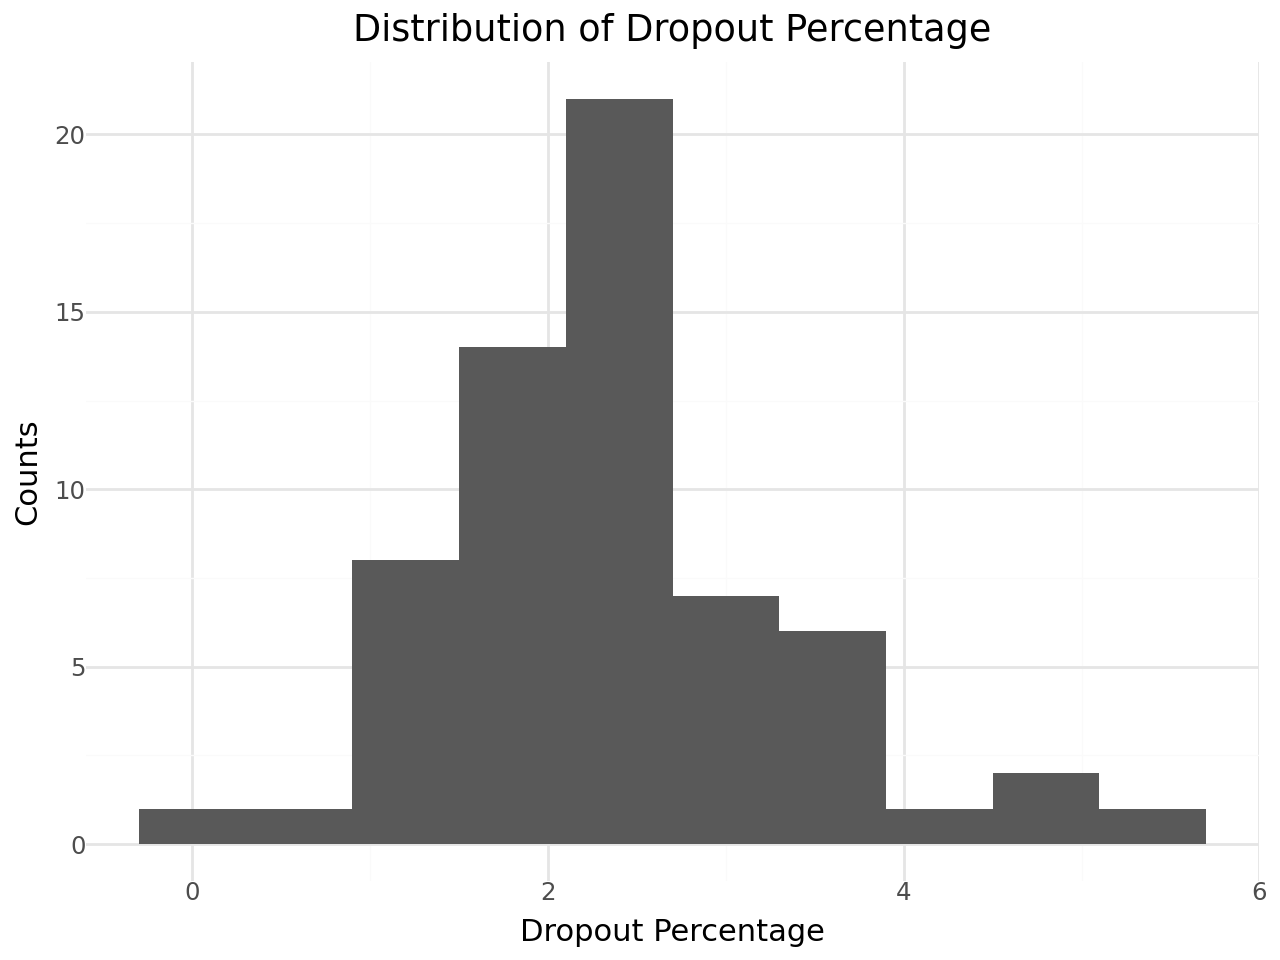

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


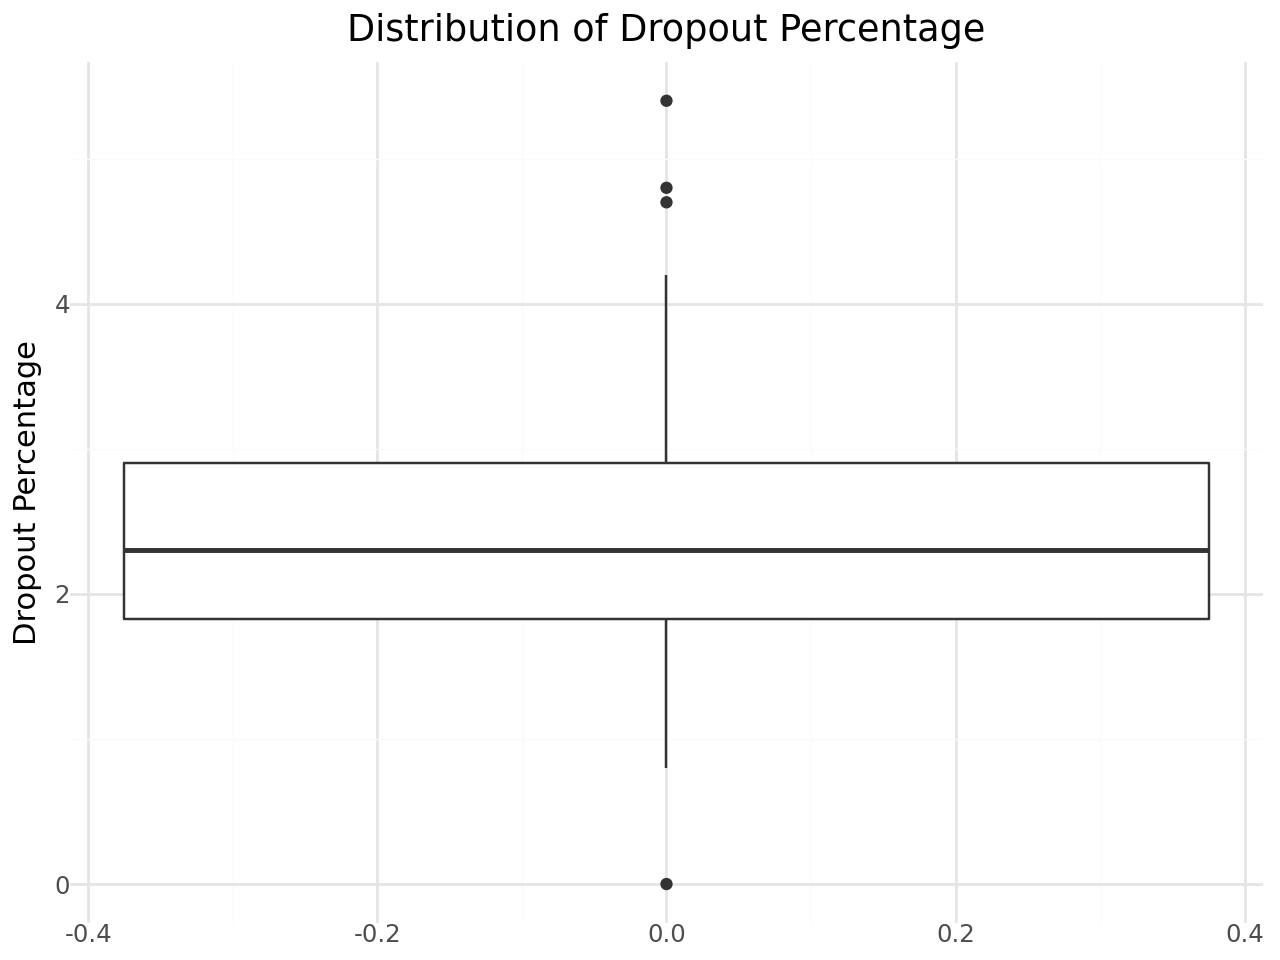


count    62.00
mean      2.45
std       0.98
min       0.00
25%       1.82
50%       2.30
75%       2.90
max       5.40
Name: Dropout Percentage, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


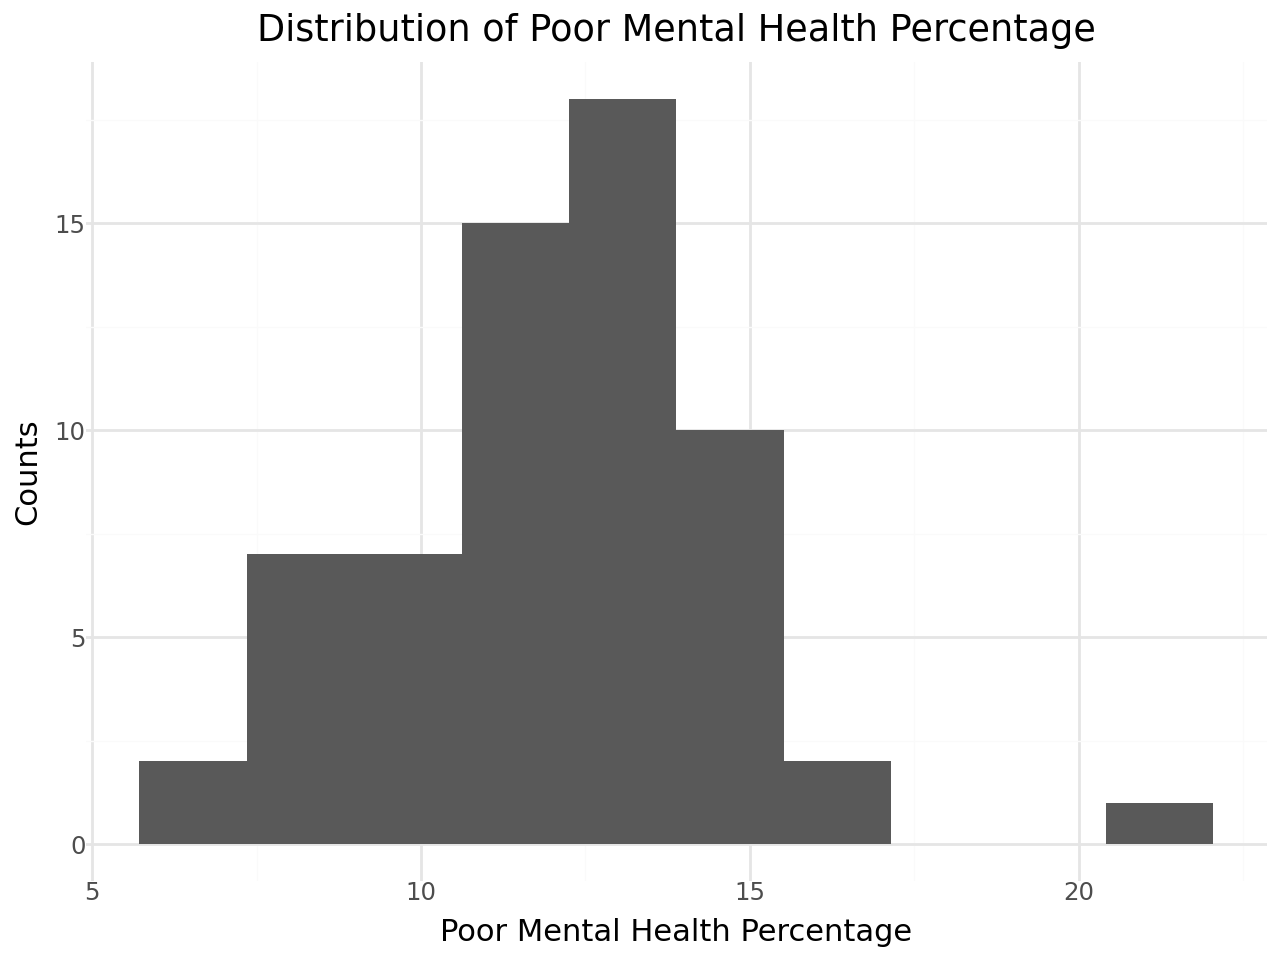

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


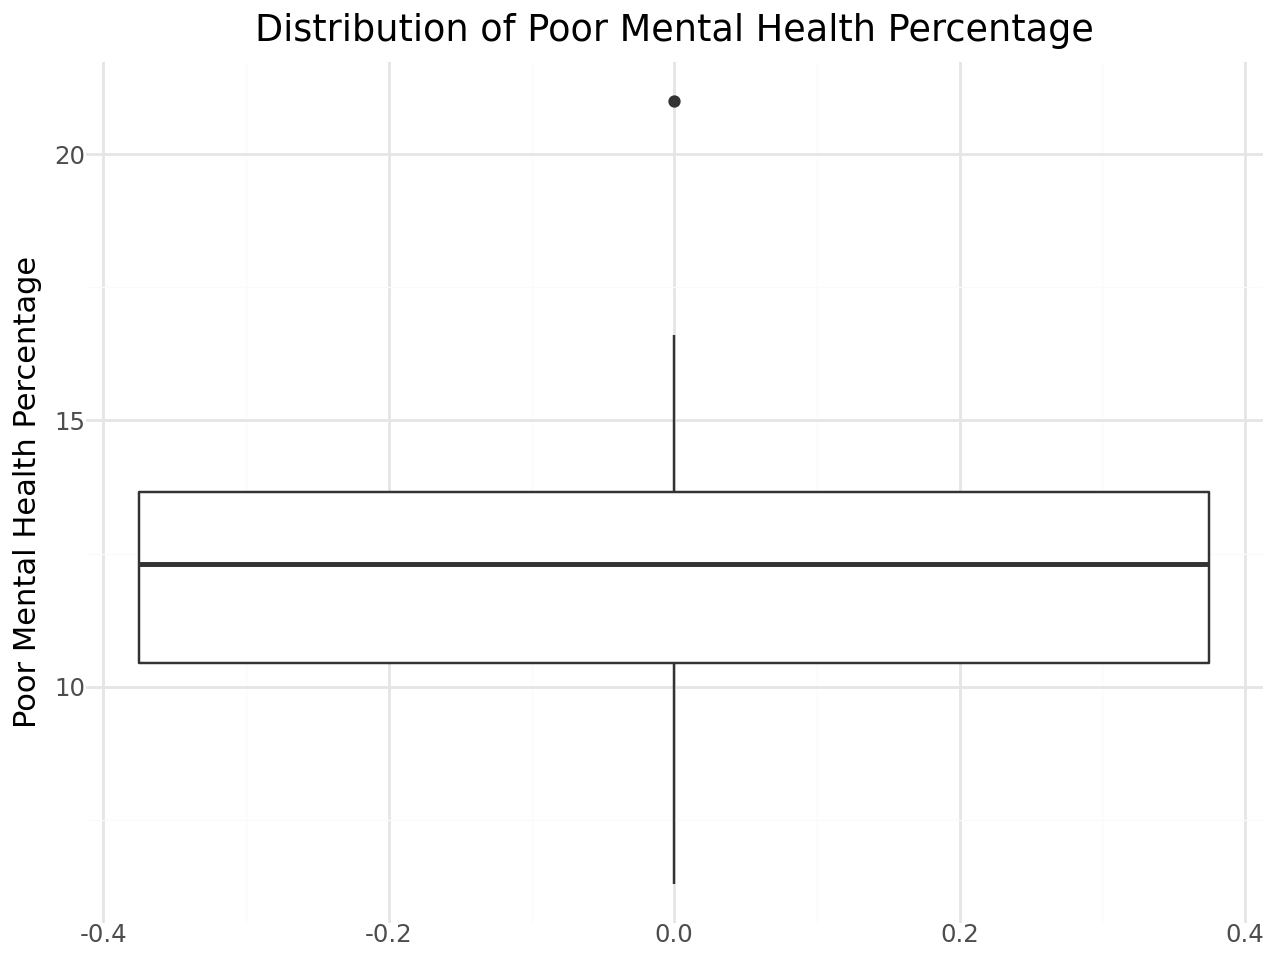


count    62.00
mean     12.06
std       2.65
min       6.30
25%      10.45
50%      12.30
75%      13.65
max      21.00
Name: Poor Mental Health Percentage, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


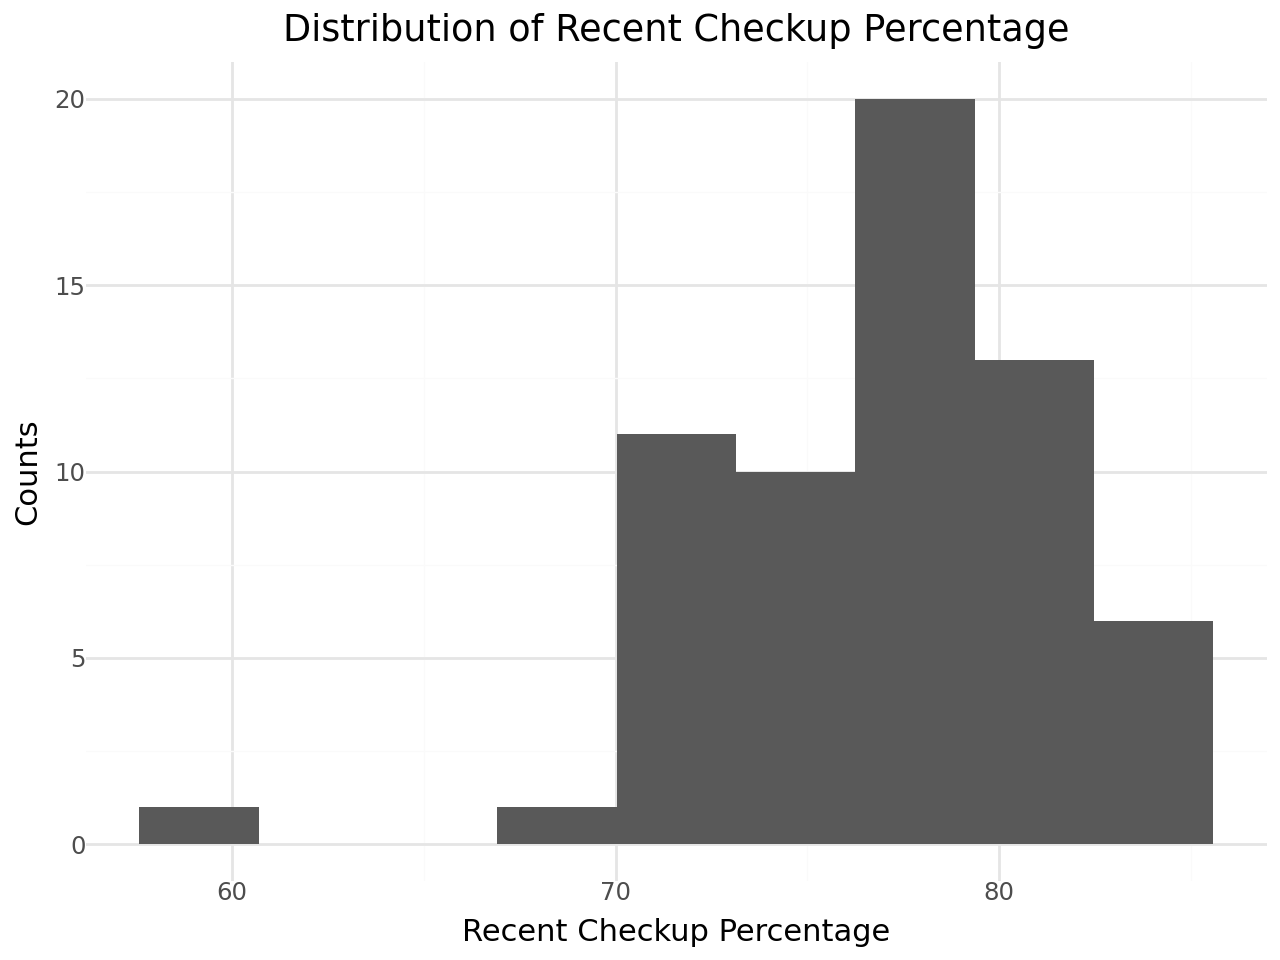

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


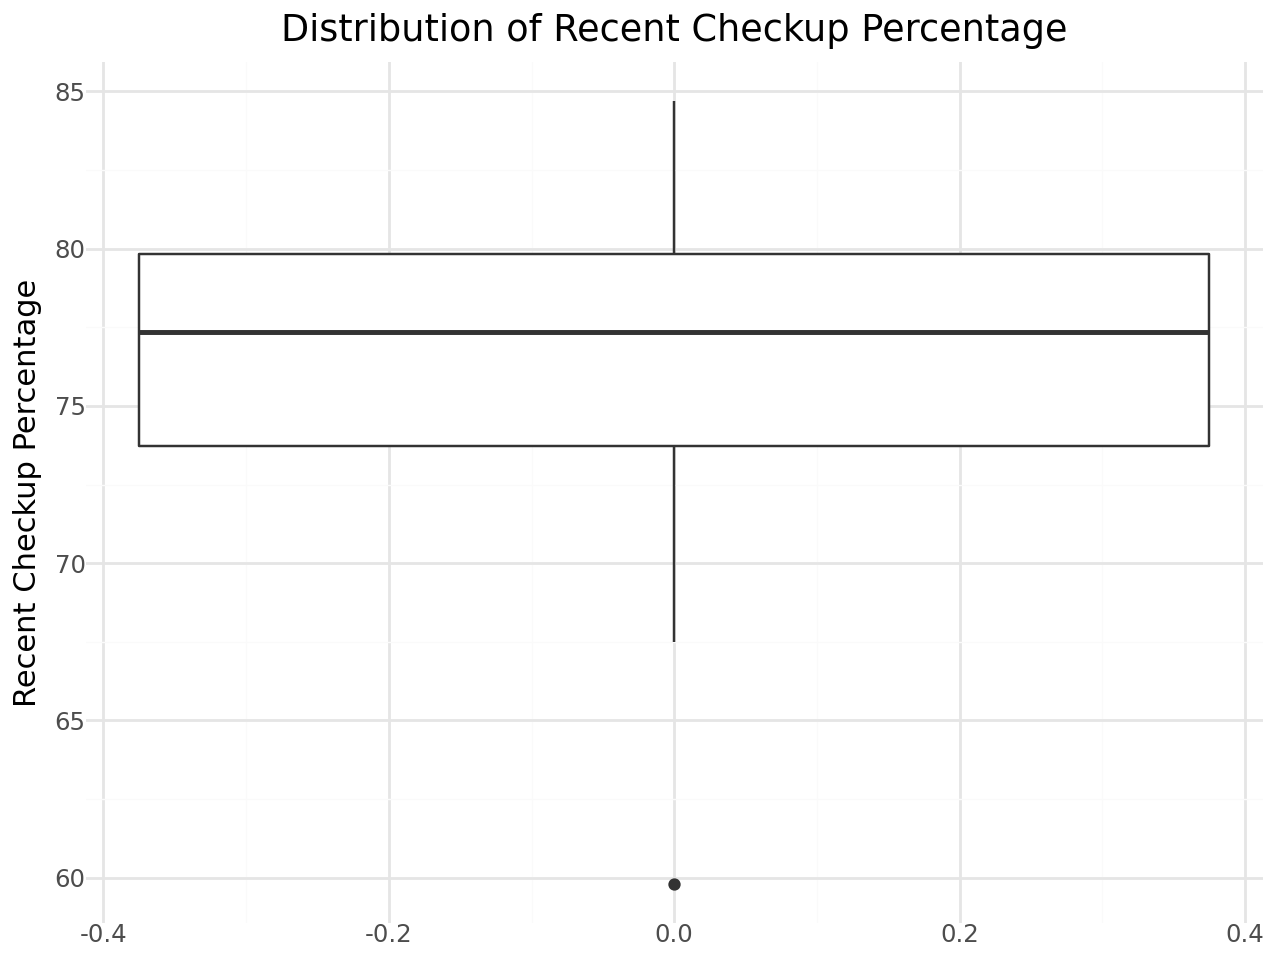


count    62.00
mean     76.85
std       4.40
min      59.80
25%      73.72
50%      77.35
75%      79.82
max      84.70
Name: Recent Checkup Percentage, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 8'. Pick better value with 'binwidth'.


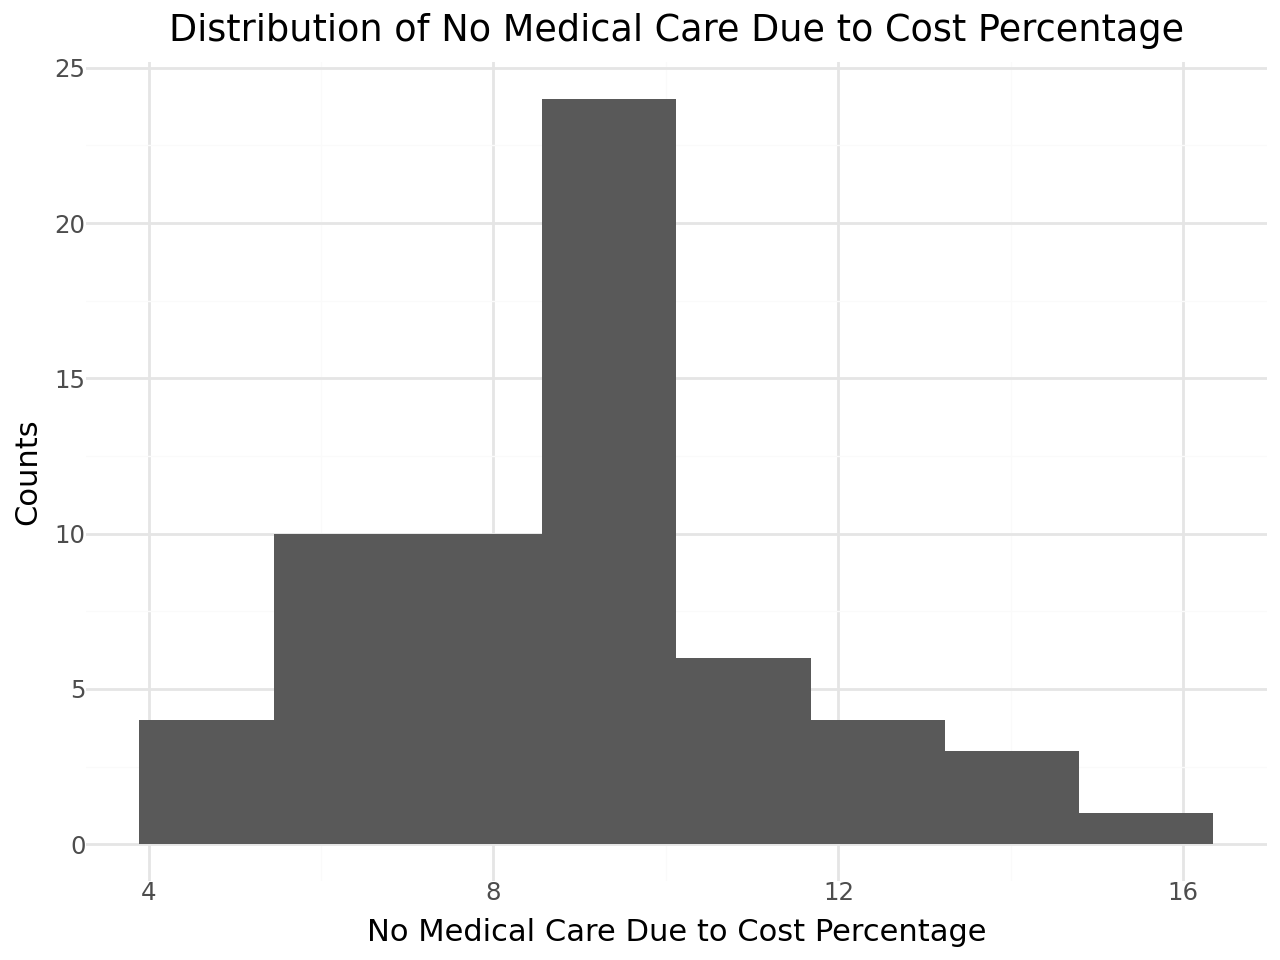

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


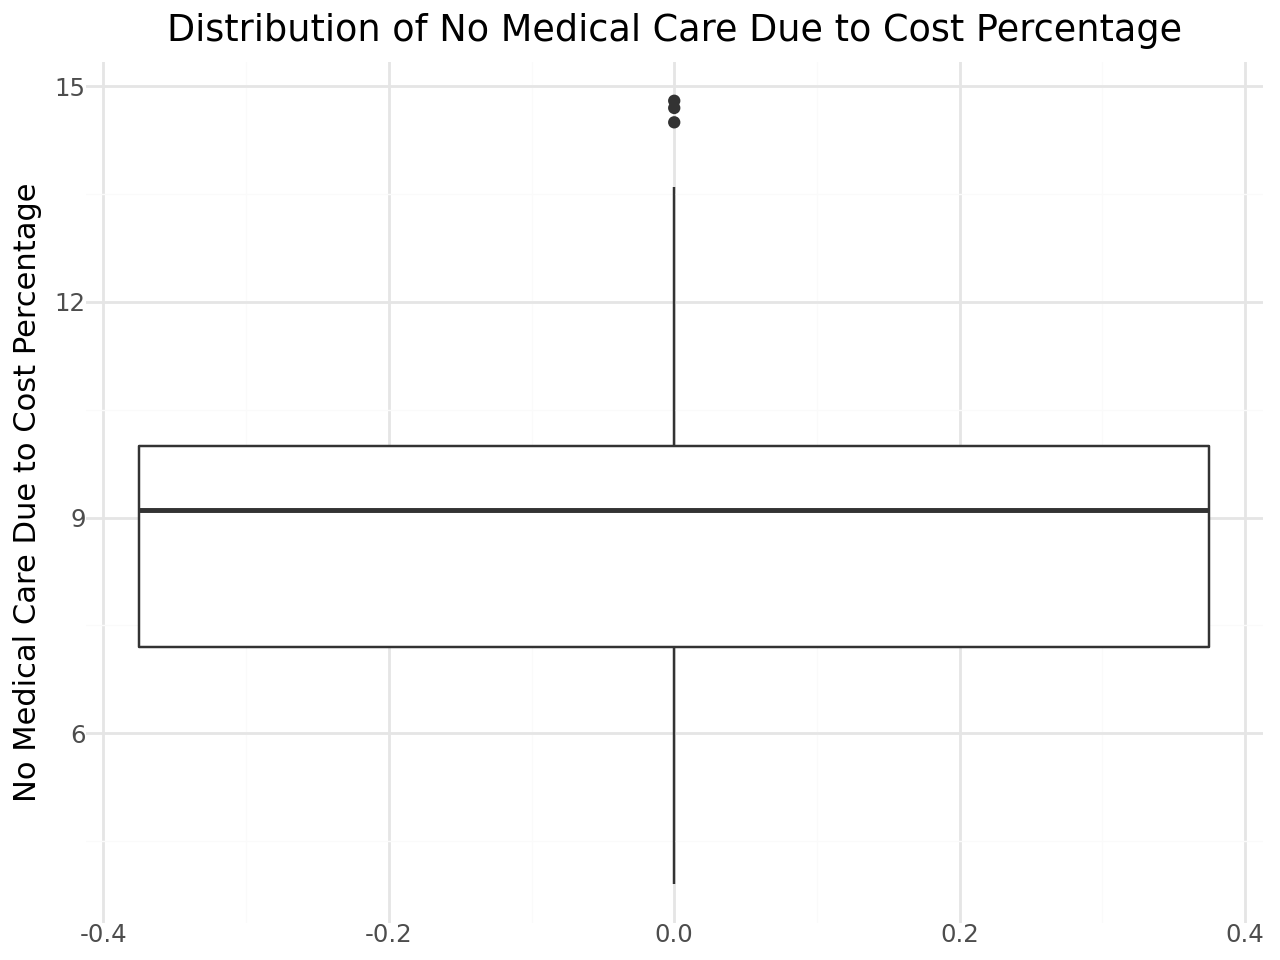


count    62.00
mean      9.00
std       2.42
min       3.90
25%       7.20
50%       9.10
75%      10.00
max      14.80
Name: No Medical Care Due to Cost Percentage, dtype: float64


C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:17: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().
C:\Users\standys\anaconda3\Lib\site-packages\plotnine\stats\stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 9'. Pick better value with 'binwidth'.


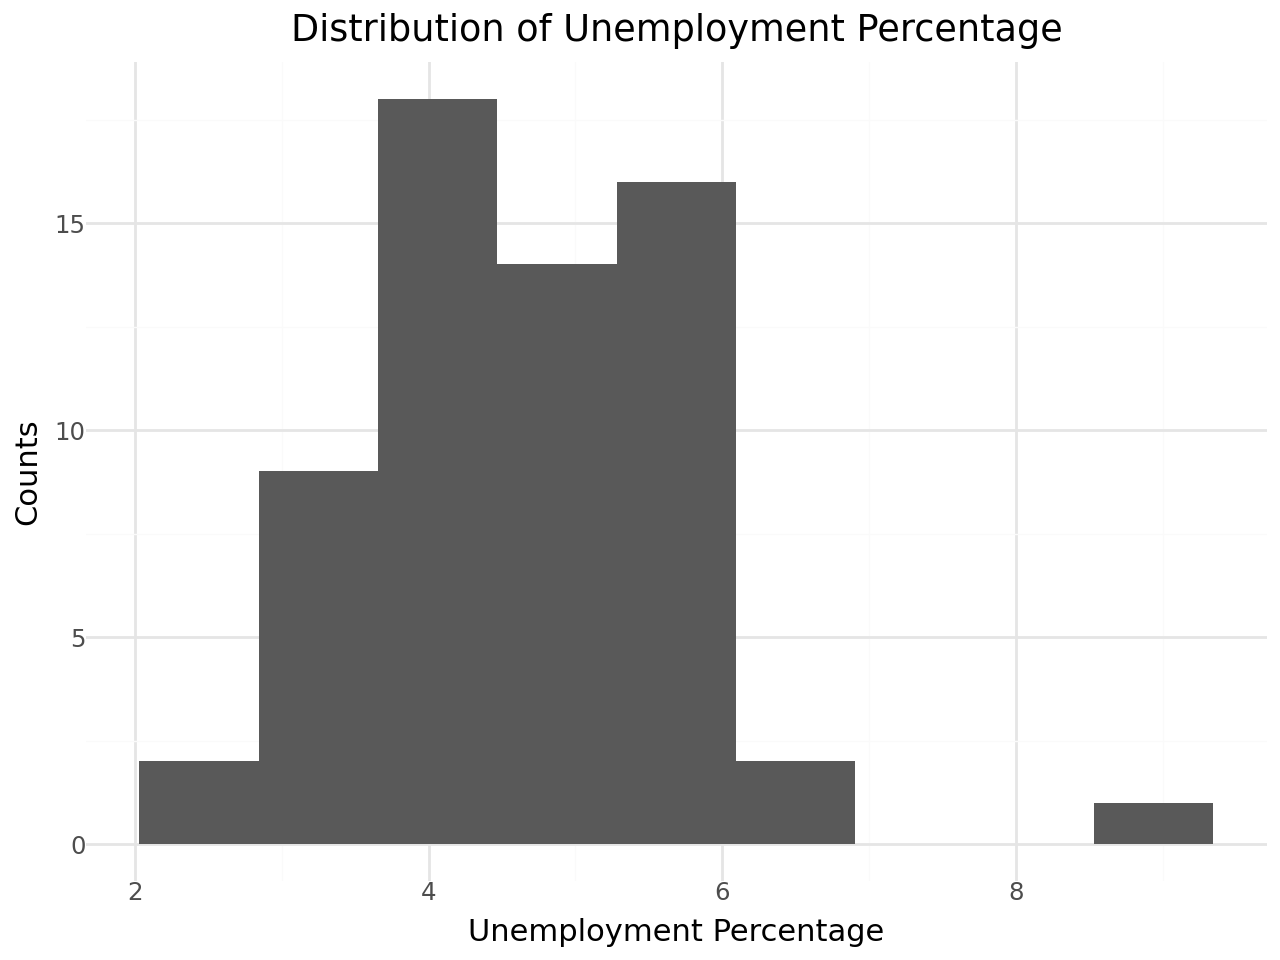

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\958134298.py:20: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


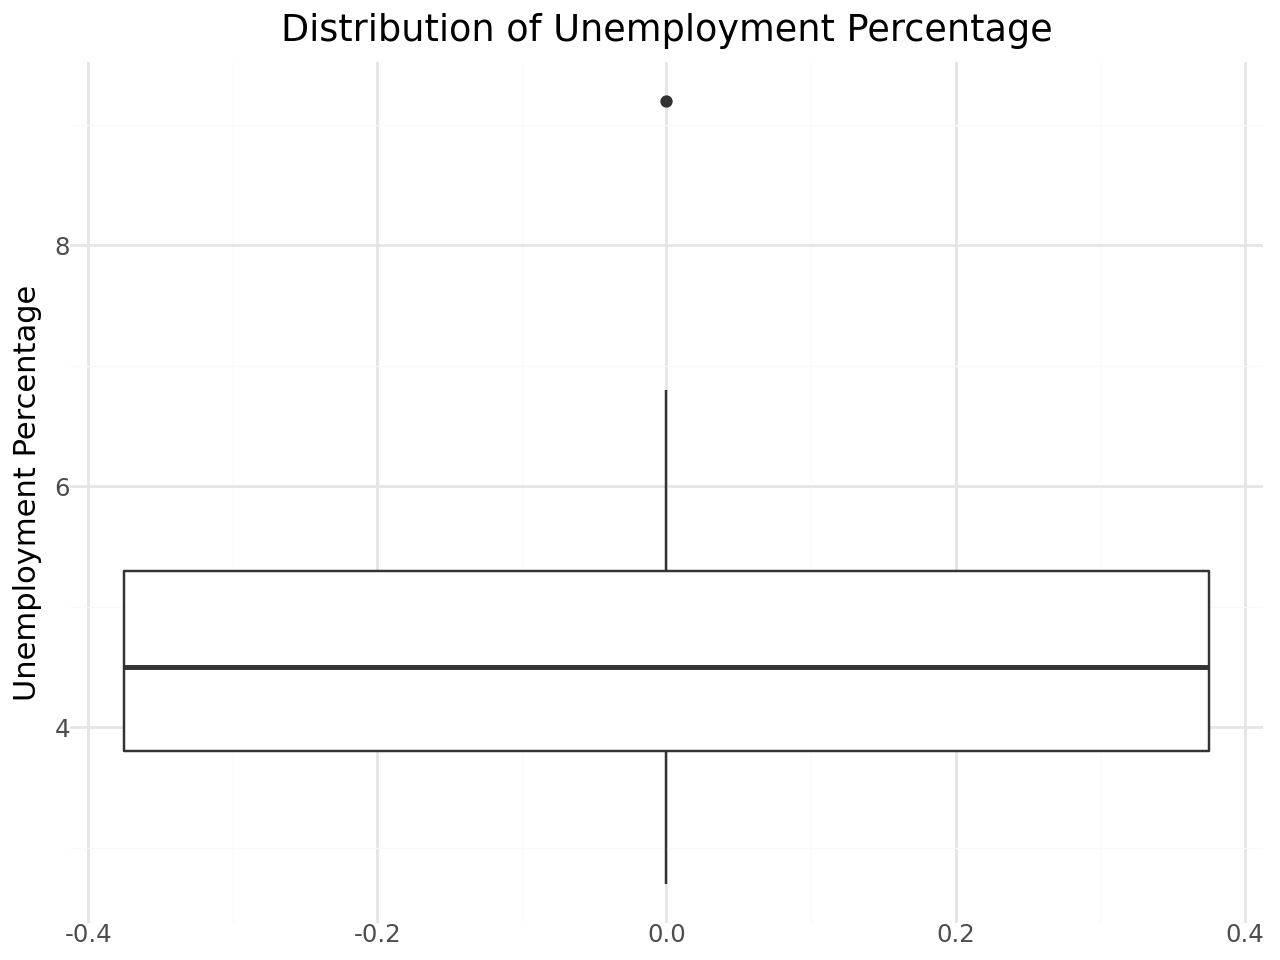


count    62.00
mean      4.63
std       1.09
min       2.70
25%       3.80
50%       4.50
75%       5.30
max       9.20
Name: Unemployment Percentage, dtype: float64


In [24]:
def analysis_histogram(df, colname:str):
  return (ggplot(df, aes(x=colname)) +
        geom_histogram() +
        theme_minimal() +
        ggtitle('Distribution of ' + colname) +
        xlab(colname) +
        ylab('Counts'))

def analysis_boxplot(df, colname:str):
  return (ggplot(df, aes(y=colname)) +
        geom_boxplot() +
        theme_minimal() +
        ggtitle('Distribution of ' + colname))

def univar_cont_analysis(df, colname:str):
  plot = analysis_histogram(df, colname)
  print(plot)

  plot = analysis_boxplot(df, colname)
  print(plot)

  print(df[colname].describe().round(2))


# OPIOIDS
univar_cont_analysis(opioids_factors, 'Opioid Deaths per 100000')

# POVERTY
univar_cont_analysis(opioids_factors, 'Poverty Percentage')

# EDUCATION
univar_cont_analysis(opioids_factors, 'Dropout Percentage')

# MENTAL HEALTH
univar_cont_analysis(opioids_factors, 'Poor Mental Health Percentage')

# RECENT CHECKUP
univar_cont_analysis(opioids_factors, 'Recent Checkup Percentage')

# NO MEDICAL CARE DUE TO COST
univar_cont_analysis(opioids_factors, 'No Medical Care Due to Cost Percentage')

# UNEMPLOYMENT
univar_cont_analysis(opioids_factors, 'Unemployment Percentage')

# BIVARIATE ANALYSIS

Very little correlation appears between our predictors and opioid death rates for New York counties:

*   Poverty percentage: r = 0.01
*   Dropout percentage: r = 0.22 (greatest correlation)
*   Poor mental health percentage: r = 0.00
*   Recent checkup percentage: r = 0.12
*   No medical care due to cost percentage: r = 0.06
*   Unemployment percentage: r = -0.27
*   Urban score: r = 0.03

Scatterplots confirm that there is little discernable correlation present. However, when splitting data into urban and rural groups, some differences between the two groups appear. The rural group still shows very little correlation, but the urban group shows a weak positive correlation for most of our predictors. This difference should be analyzed further in a split urban/rural analysis.




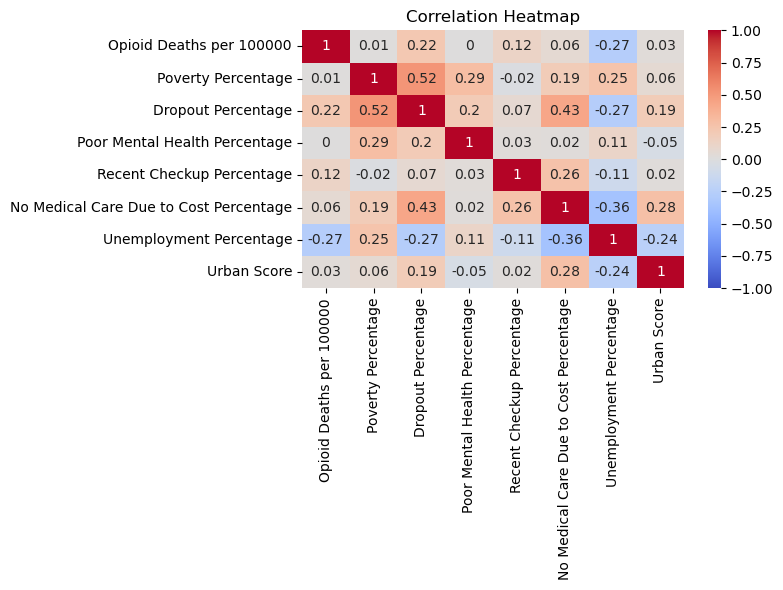

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:35: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


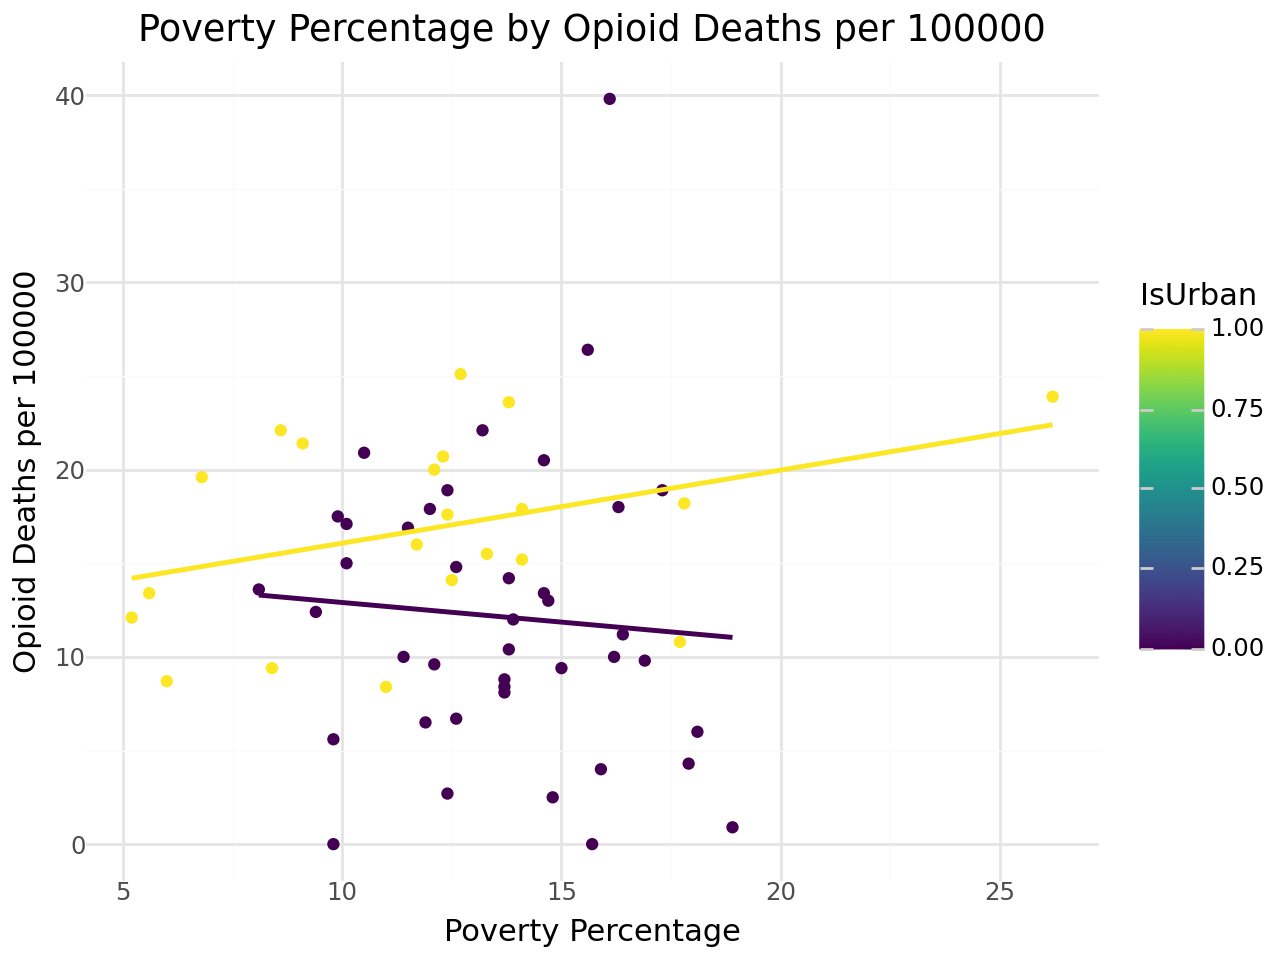

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:38: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


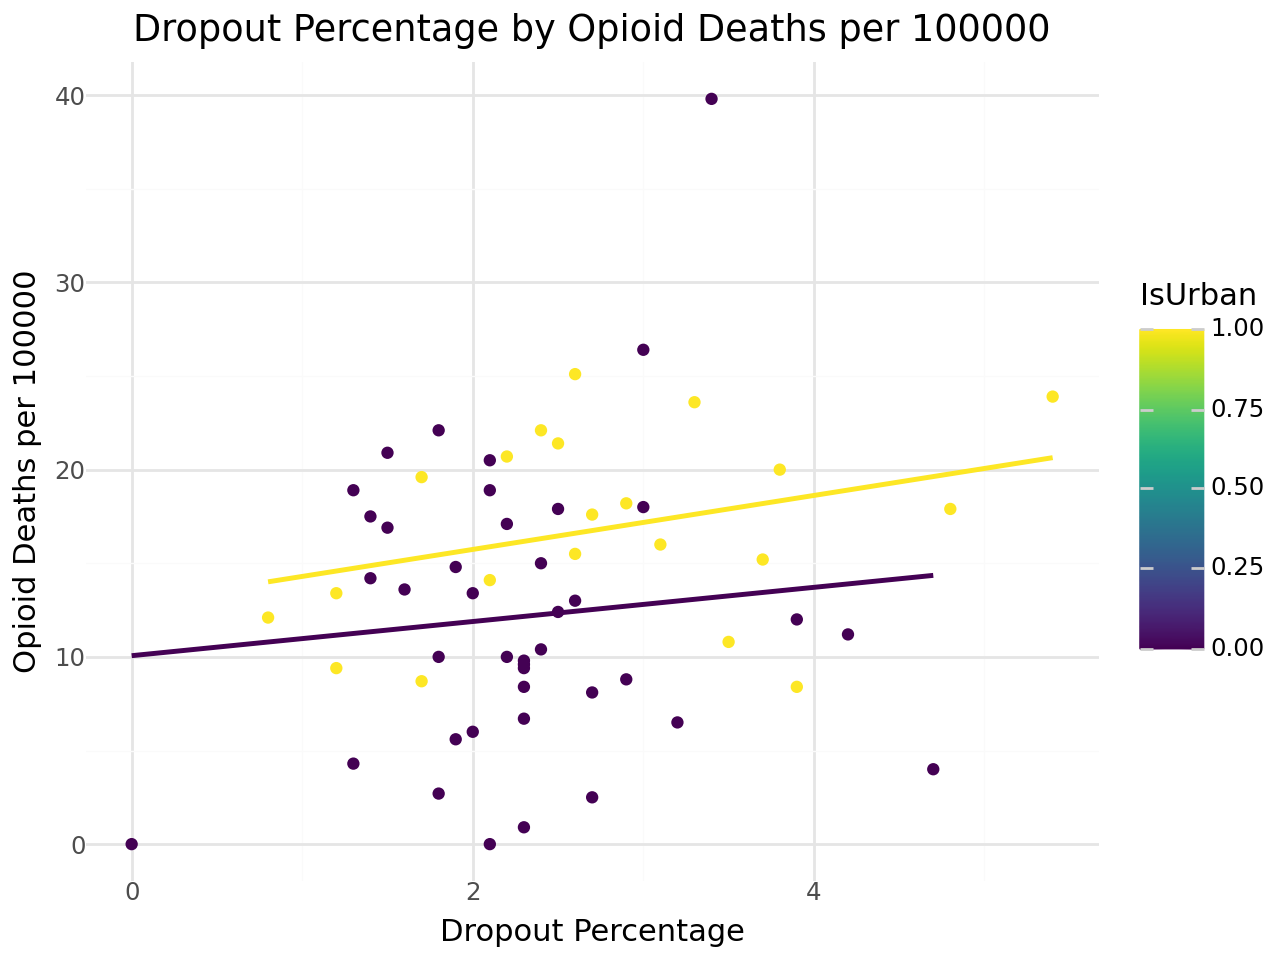

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:41: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


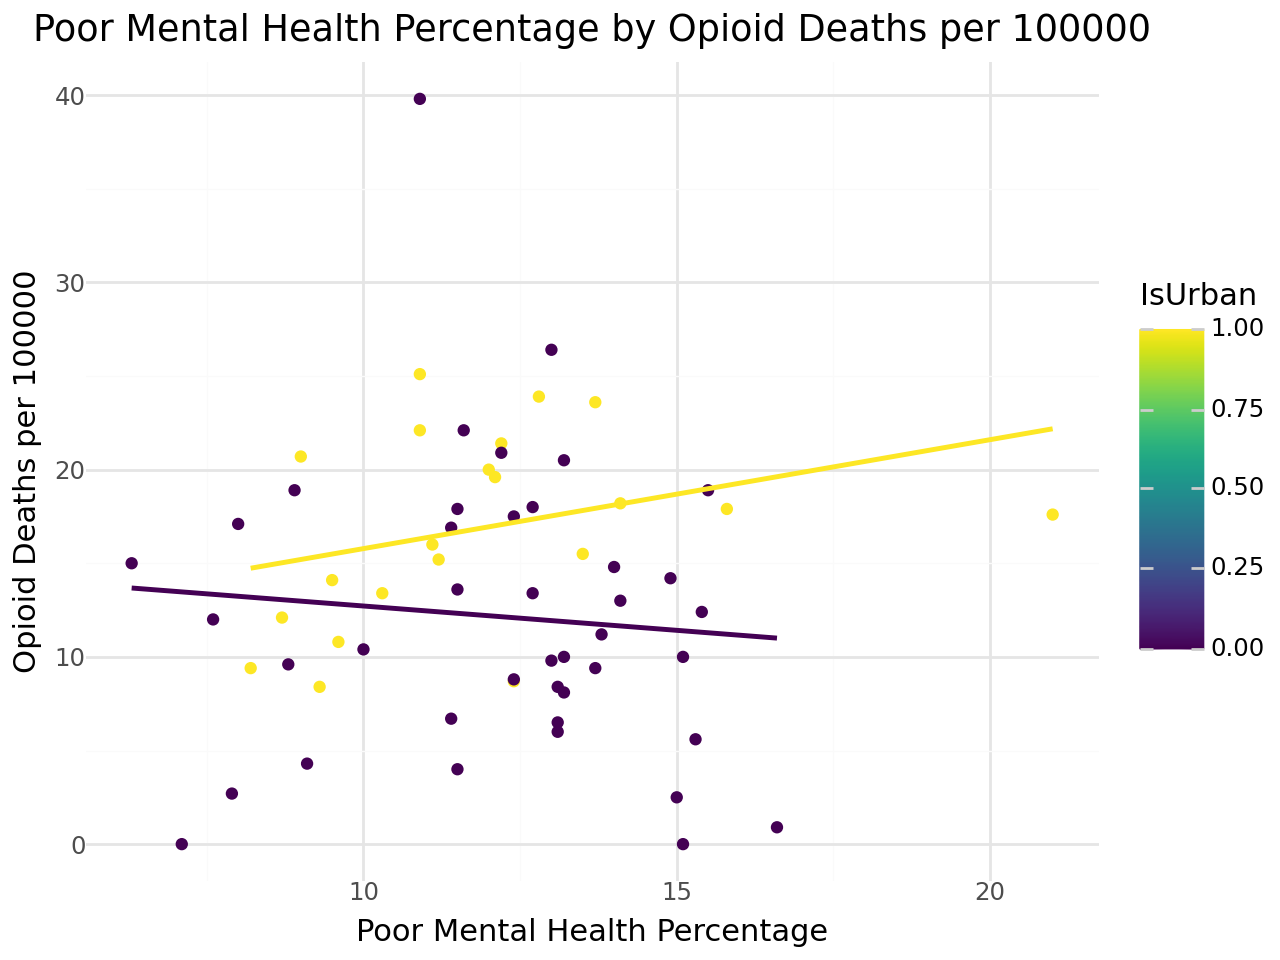

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:44: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


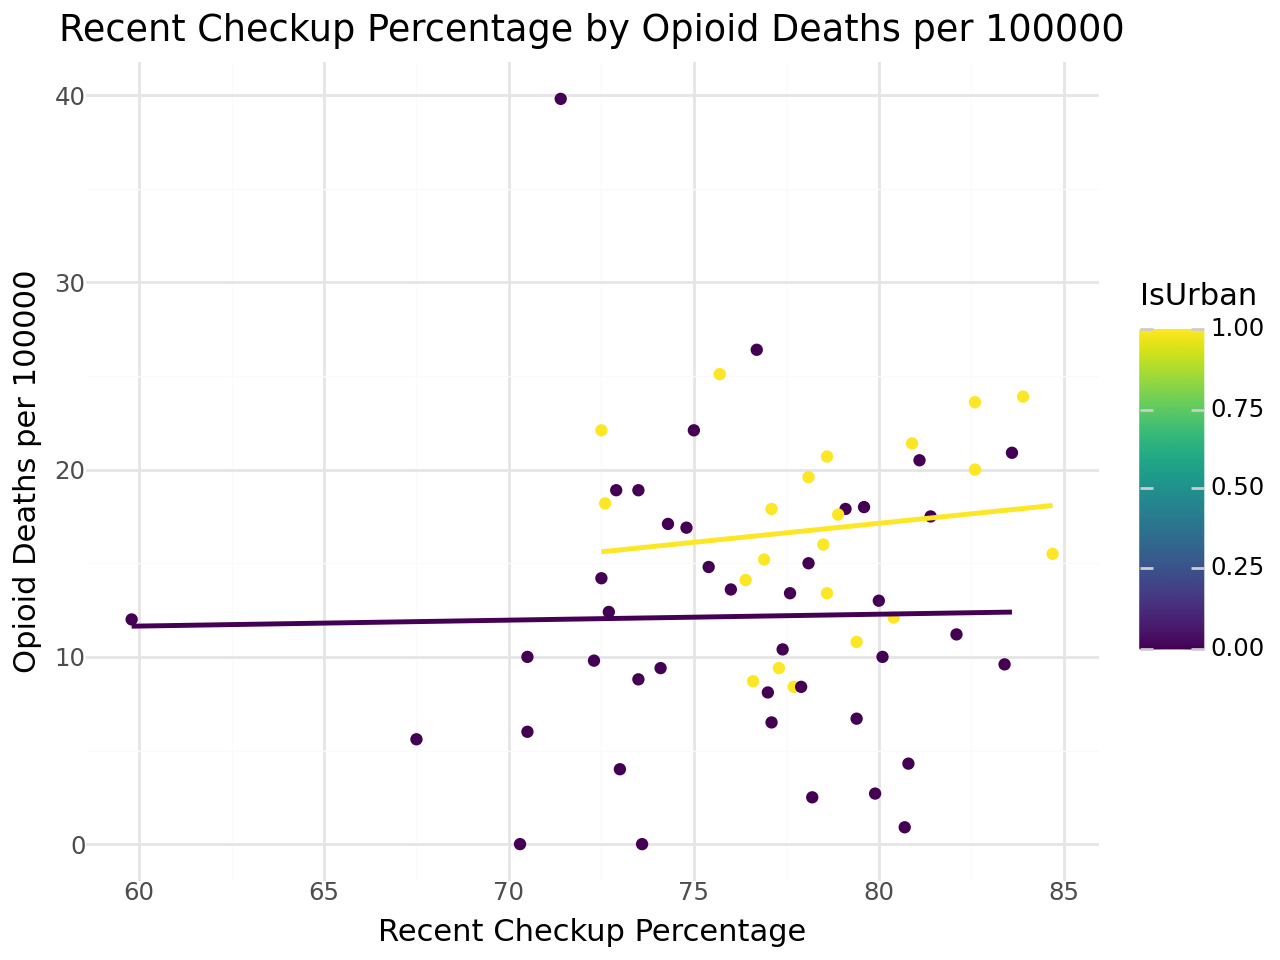

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:47: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


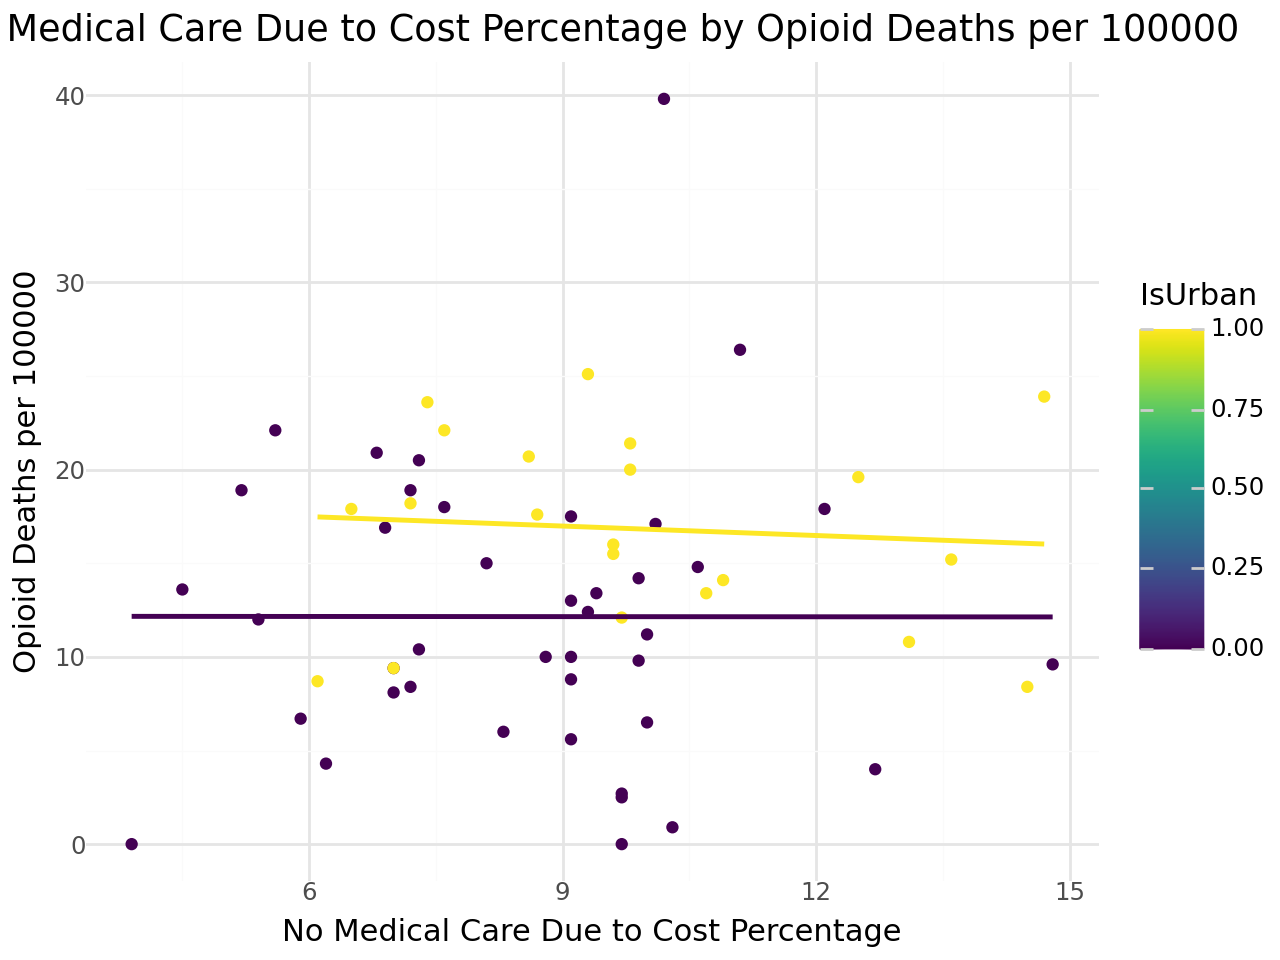

C:\Users\standys\AppData\Local\Temp\ipykernel_8880\3903188449.py:50: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


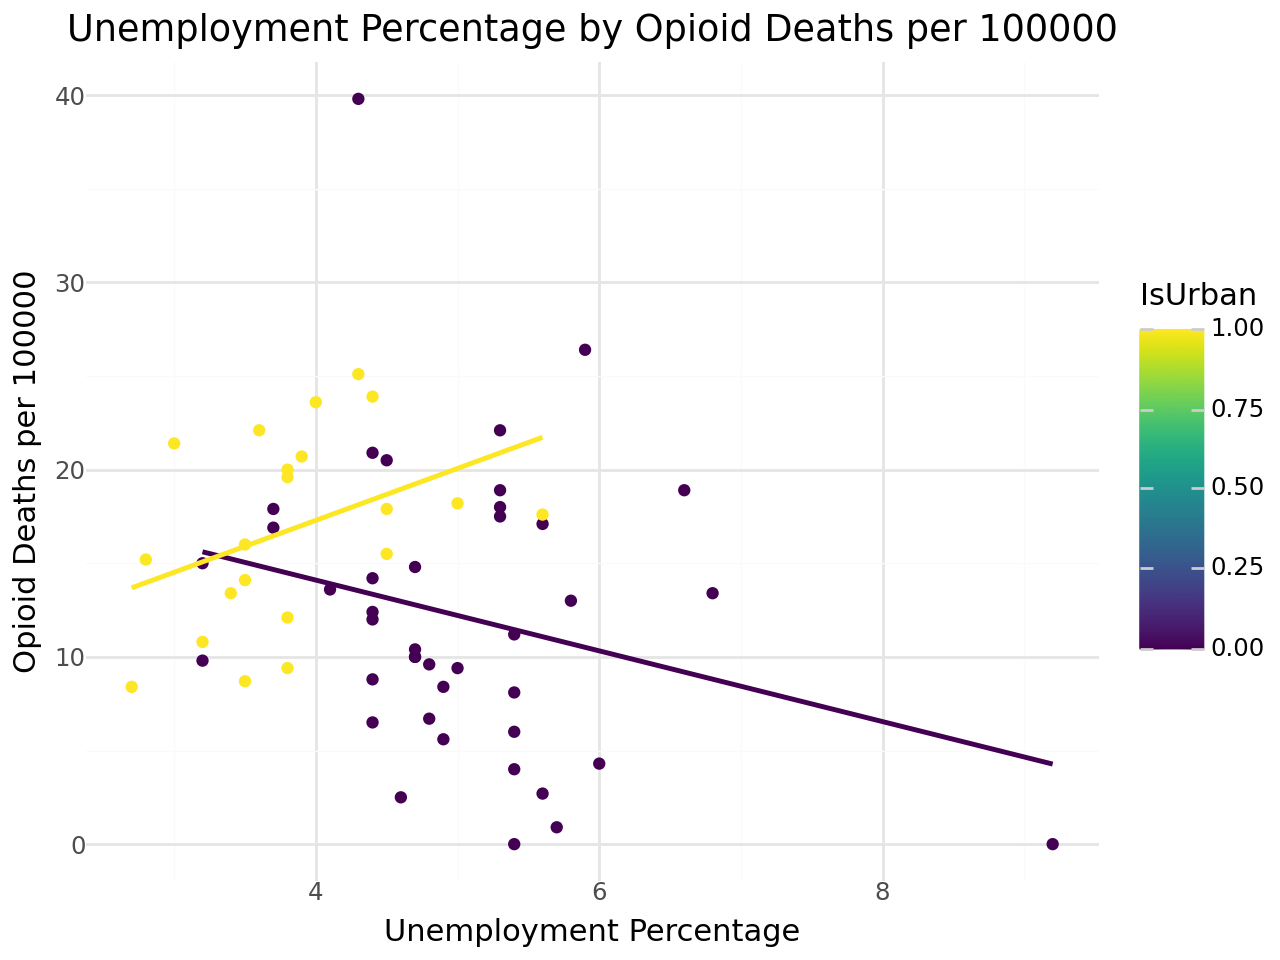

In [26]:
def analysis_scatterplot(df, xcol:str, ycol:str, strat):
  return (ggplot(df, aes(x=xcol, y=ycol, color=strat)) +
        geom_point() +
        geom_smooth(aes(group=strat), method='lm', se=False) +
        theme_minimal() +
        ggtitle(xcol + ' by ' + ycol) +
        xlab(xcol) +
        ylab(ycol))

def show_correlation_heatmap(corr):
  plt.figure(figsize=(8, 6))
  sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Correlation Heatmap')
  plt.tight_layout()
  plt.show()

strat = 'IsUrban'
response = 'Opioid Deaths per 100000'

# RATES CORRELATIONS
corr = opioids_factors[[
    'Opioid Deaths per 100000',
    'Poverty Percentage',
    'Dropout Percentage',
    'Poor Mental Health Percentage',
    'Recent Checkup Percentage',
    'No Medical Care Due to Cost Percentage',
    'Unemployment Percentage',
    'Urban Score'
    ]].corr().round(2)

show_correlation_heatmap(corr)

# OPIOIDS AND POVERTY
print(analysis_scatterplot(opioids_factors, 'Poverty Percentage', response, strat))

# OPIOIDS AND DROPOUTS
print(analysis_scatterplot(opioids_factors, 'Dropout Percentage', response, strat))

# OPIOIDS AND MENTAL HEALTH
print(analysis_scatterplot(opioids_factors, 'Poor Mental Health Percentage', response, strat))

# OPIOIDS AND RECENT CHECKUP
print(analysis_scatterplot(opioids_factors, 'Recent Checkup Percentage', response, strat))

# OPIOIDS AND NO MEDICAL CARE
print(analysis_scatterplot(opioids_factors, 'No Medical Care Due to Cost Percentage', response, strat))

# OPIOIDS AND UNEMPLOYMENT
print(analysis_scatterplot(opioids_factors, 'Unemployment Percentage', response, strat))

# SPLIT URBAN/RURAL ANALYSIS

Correlations emerge more clearly when separating counties into urban and rural groups. Compared to a combined urban/rural analysis, New York urban counties have stronger correlations between opioid deaths and most of our predictors.

Correlations with opioid death rates for urban counties:
*   Poverty percentage: r = 0.37
*   Dropout percentage: r = 0.33
*   Poor mental health percentage: r = 0.33
*   Recent checkup percentage: r = 0.13
*   No medical care due to cost percentage: r = -0.08
*   Unemployment percentage: r = 0.38

However, opioid death rates in New York rural counties show very little correlation with each of these predictors.

Correlations with opioid death rates for rural counties:
*   Poverty percentage: r = -0.07
*   Dropout percentage: r = 0.10
*   Poor mental health percentage: r = -0.09
*   Recent checkup percentage: r = 0.02
*   No medical care due to cost percentage: r = -0.00
*   Unemployment percentage: r = -0.25

The magnitude of our correlations, across the board, are still quite low, with the strongest correlation being between unemployment percentage and opioid death rates within urban NY counties (r = 0.38). What is most striking, however, is the difference in correlations between urban and rural counties. For example, the unemployment percentage predictor has a correlation of 0.38 for urban counties, but -0.25 for urban counties (a difference of 0.63 between the two). This shows that the conditions leading to opioid death rates may differ between urban and rural areas within New York.

Therefore, further analysis should be performed when splitting counties into urban and rural areas. The problem with this approach, however, is that we run low on data within each group from which to draw conclusive results. There are a total of 62 counties in New York which we've been analyzing -- already a fairly limited number. When we split these groups into urban and rural, however, our sample sizes drop to 21 for urban and 41 for rural -- too few to perform a more confident and detailed analysis.

So, to pursue a split urban-rural analysis of opioid death predictors, we should expand our dataset to include not only New York counties, but counties across the US. This analysis will be more complex, but may produce clearer and more reliable results due to the increased sample size.



-------URBAN-------


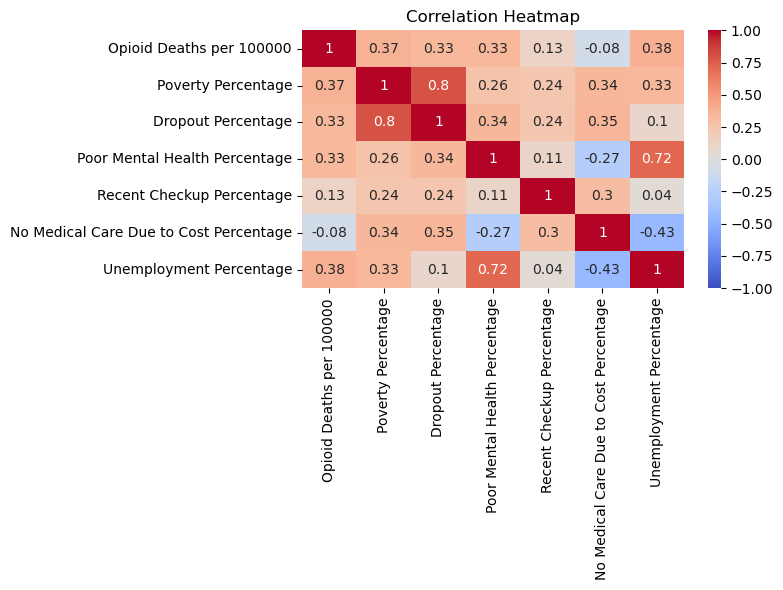

-------RURAL-------


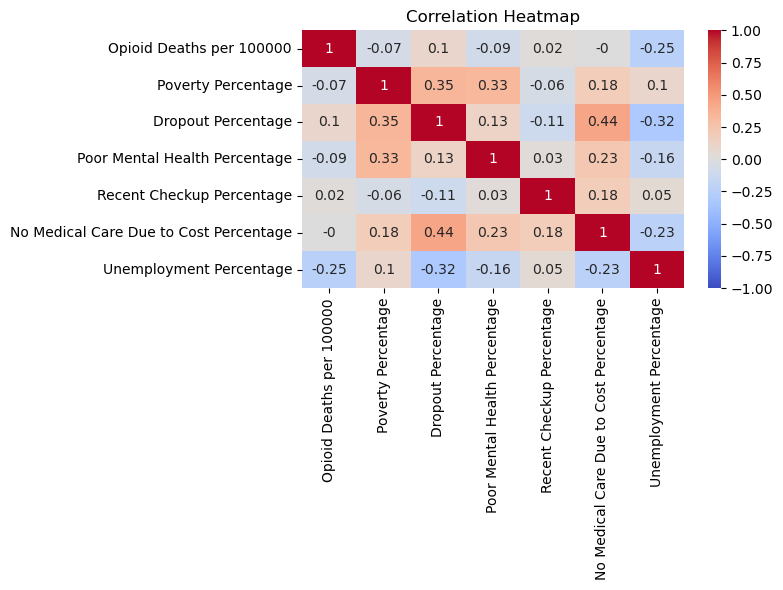

In [28]:
opioids_factors_urban = opioids_factors[opioids_factors['IsUrban'] == 1]
opioids_factors_rural = opioids_factors[opioids_factors['IsUrban'] == 0]

# RATES CORRELATIONS - URBAN
corr = opioids_factors_urban[[
    'Opioid Deaths per 100000',
    'Poverty Percentage',
    'Dropout Percentage',
    'Poor Mental Health Percentage',
    'Recent Checkup Percentage',
    'No Medical Care Due to Cost Percentage',
    'Unemployment Percentage'
    ]].corr().round(2)

print('-------URBAN-------')
show_correlation_heatmap(corr)

# RATES CORRELATIONS - RURAL
corr = opioids_factors_rural[[
    'Opioid Deaths per 100000',
    'Poverty Percentage',
    'Dropout Percentage',
    'Poor Mental Health Percentage',
    'Recent Checkup Percentage',
    'No Medical Care Due to Cost Percentage',
    'Unemployment Percentage'
    ]].corr().round(2)

print('-------RURAL-------')
show_correlation_heatmap(corr)

# REGRESSIONS

Currently, we do not have features with sufficient correlations from which to build a useful predictive model, whether we're dealing with combined data or split urban/rural data. This codeblock will remain, however, as a stub from which to build a predictive model if stronger correlations are found.

In [30]:
def regression_analysis(df):
  # feature selection
  y = df['Opioid Deaths per 100000']
  X = df[[
      'Dropout Percentage',
      'Recent Checkup Percentage',
      'Unemployment Percentage'
  ]]

  # split
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

  # train linear model
  model = LinearRegression()
  model.fit(X_train, y_train)

  # generate predictions
  y_pred = model.predict(X_test)

  # evaluate model
  print("Coefficients: ", model.coef_.round(2))
  print("Intercept: ", model.intercept_.round(2))
  print("MSE: ", mean_squared_error(y_test, y_pred).round(2))
  print("MAE: ", mean_absolute_error(y_test, y_pred).round(2))
  print("R2: ", r2_score(y_test, y_pred).round(2))

regression_analysis(opioids_factors)
regression_analysis(opioids_factors_urban)
regression_analysis(opioids_factors_rural)

Coefficients:  [ 0.45  0.21 -1.25]
Intercept:  1.81
MSE:  71.04
MAE:  5.64
R2:  0.14
Coefficients:  [1.07 0.32 2.73]
Intercept:  -21.89
MSE:  23.69
MAE:  3.65
R2:  -0.14
Coefficients:  [ 3.45 -0.   -0.6 ]
Intercept:  7.61
MSE:  69.23
MAE:  7.24
R2:  -1.61


# RESULTS

The analysis conducted on the relationship between socio-economic factors and opioid overdose deaths across counties in New York State revealed several key insights:

## Univariate Analysis
Each of the variables studied—poverty percentage, dropout percentage, poor mental health percentage, recent checkup percentage, lack of access to medical care due to cost percentage, and unemployment percentage—was examined individually. The distributions were generally normal with some minor outliers. None of these outliers significantly skewed the data, so we did not remove or alter any data points before analysis.

## Bivariate Analysis

The bivariate analysis indicates minimal correlation between the predictors and opioid death rates across New York counties:

* Poverty percentage: r = 0.01
* Dropout percentage: r = 0.22
* Poor mental health percentage: r = 0.00
* Recent checkup percentage: r = 0.12
* No medical care due to cost percentage: r = 0.06
* Unemployment percentage: r = -0.27
* Urban score: r = 0.03

Scatterplots reinforce the lack of discernible correlation. However, when the data is divided into urban and rural groups, notable differences emerge. While the rural group continues to show minimal correlation, the urban group exhibits a weak positive correlation for most predictors. This suggests that further analysis should explore the urban-rural divide in more detail.

## Split Urban vs. Rural Analysis
When splitting the data into urban and rural counties, some trends became clearer:

* Urban Counties: Correlations with opioid death rates were generally stronger in urban areas, particularly for unemployment (r = 0.38), poverty (r = 0.37), and poor mental health (r = 0.33).
* Rural Counties: In contrast, rural areas showed weak or negative correlations across all factors, with unemployment showing a negative correlation (r = -0.25) with opioid deaths.

The differences between urban and rural correlations suggest that the socio-economic dynamics influencing opioid deaths may vary significantly between these environments. Opioid death rates in urban areas seem to be more sensitive to changes in socio-economic conditions, while in rural areas they may be influenced by other factors. However, more data is needed to further explore these results, as the split analysis used small sample sizes (only 21 urban counties and 41 rural counties).

## Regression Analysis
Due to the weak correlations observed, a reliable predictive model for opioid deaths could not be built using the current dataset. The strongest correlations in urban areas (e.g., unemployment) were still not robust enough to produce a model with high predictive power. Further analysis with more data may be helpful.

## Conclusion
This analysis highlights the complexity of opioid-related fatalities and the need for further exploration with more comprehensive data. The difference in correlations between urban and rural counties indicates that different strategies may be required to address opioid deaths in these areas. The next steps will involve expanding the dataset to include national data, which will increase the sample size and may help in uncovering more definitive trends. This approach should allow for a more detailed exploration of the factors contributing to opioid deaths across various socio-economic landscapes.